In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel

%matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
input_path = '../input/'
model_path = '../model/'

In [3]:
# Load raw POIs
num_pois = pd.read_csv(input_path + 'spatial_num_pois_raw.csv', index_col='index')
name_pois = pd.read_csv(input_path + 'spatial_name_pois_raw.csv', index_col='index')

In [4]:
num_pois.columns

Index(['amenity college', 'amenity school', 'amenity university',
       'building school', 'building university', 'craft', 'building retail',
       'building supermarket', 'amenity marketplace', 'shop bakery',
       'shop beverages', 'shop butcher', 'shop convenience',
       'shop greengrocer', 'shop department_store', 'shop general',
       'shop mall', 'shop supermarket', 'shop clothes', 'shop shoes',
       'shop garden_centre', 'shop doityourself', 'shop hardware',
       'amenity clinic', 'amenity doctors', 'amenity hospital',
       'amenity pharmacy', 'amenity post_depot', 'amenity post_office',
       'building hospital', 'amenity bar', 'amenity biergarten',
       'amenity cafe', 'amenity pub', 'amenity restaurant',
       'amenity arts_centre', 'amenity cinema', 'amenity community_centre',
       'amenity events_venue', 'amenity nightclub', 'amenity theatre',
       'amenity place_of_worship', 'amenity public_bath', 'building stadium',
       'leisure beach_resort', 'leis

In [5]:
len(num_pois.columns)

63

In [6]:
# How many zones with comparably few POIs (no zone has under 100)?
len(num_pois.loc[num_pois.sum(axis=1)<500])

5

<AxesSubplot:>

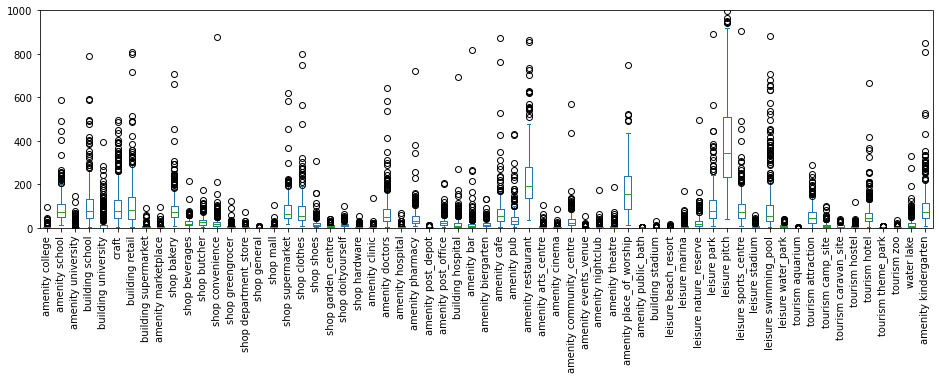

In [7]:
# Average POI numbers
num_pois.plot.box(figsize=(16,4), rot=90, ylim=(0,1000))

<AxesSubplot:>

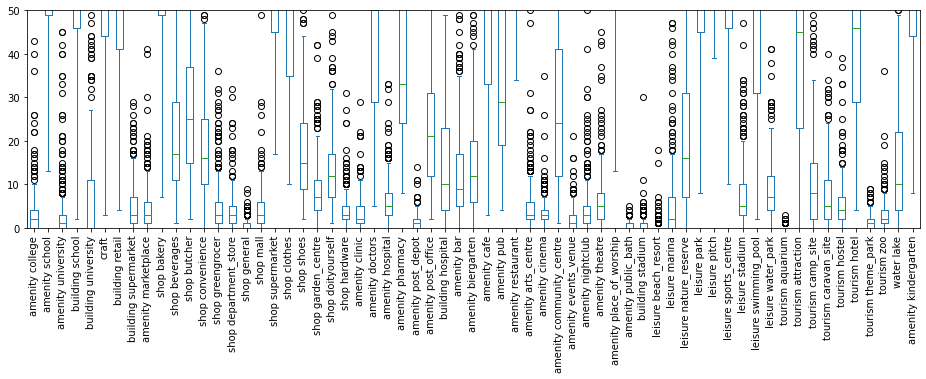

In [8]:
# ZOOM Average POI numbers
num_pois.plot.box(figsize=(16,4), rot=90, ylim=(0,50))

In [9]:
# Load zone attributes and geometries
sm = stepmodel.read_json(model_path + 'de_zones')
sm.zones = gpd.GeoDataFrame(sm.zones)

In [10]:
sm.zones[list(num_pois.columns)] = num_pois[list(num_pois.columns)]

Average POIs by urbanisation degree (1=urban, 3=rural)


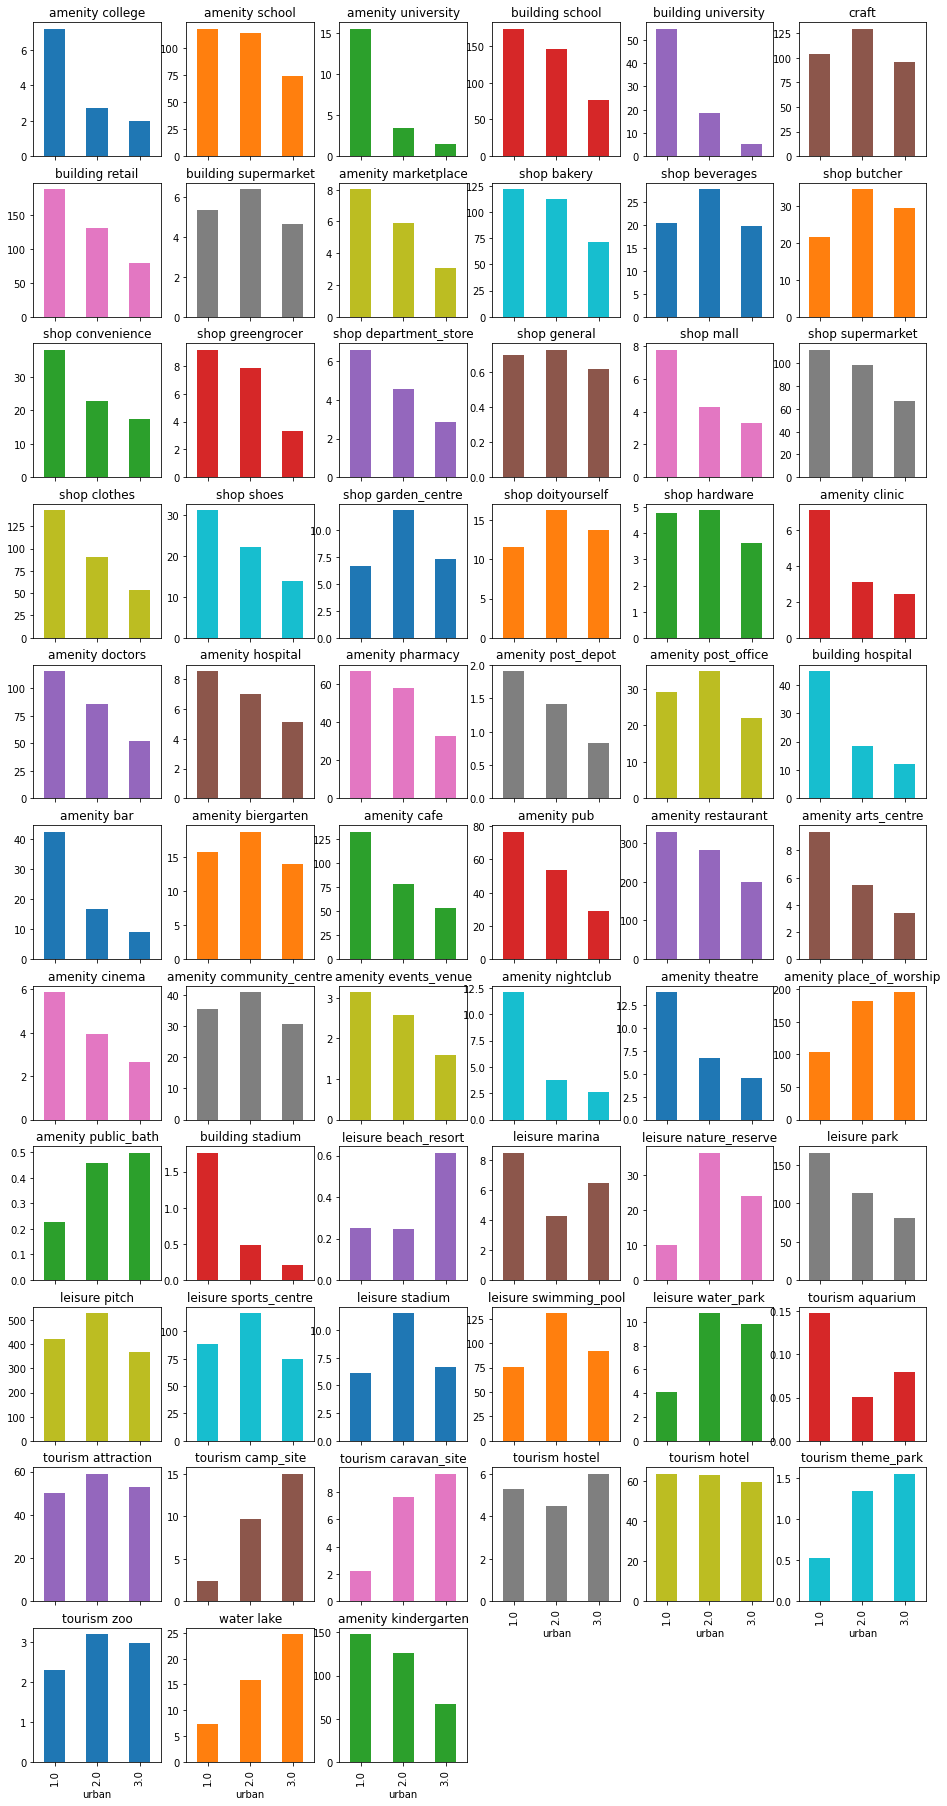

In [19]:
sm.zones.groupby('urbanisation').mean()[list(num_pois.columns)].plot.bar(
    subplots=True, figsize=(16,32), layout=(11,6), legend=False)
print('Average POIs by urbanisation degree (1=urban, 3=rural)')

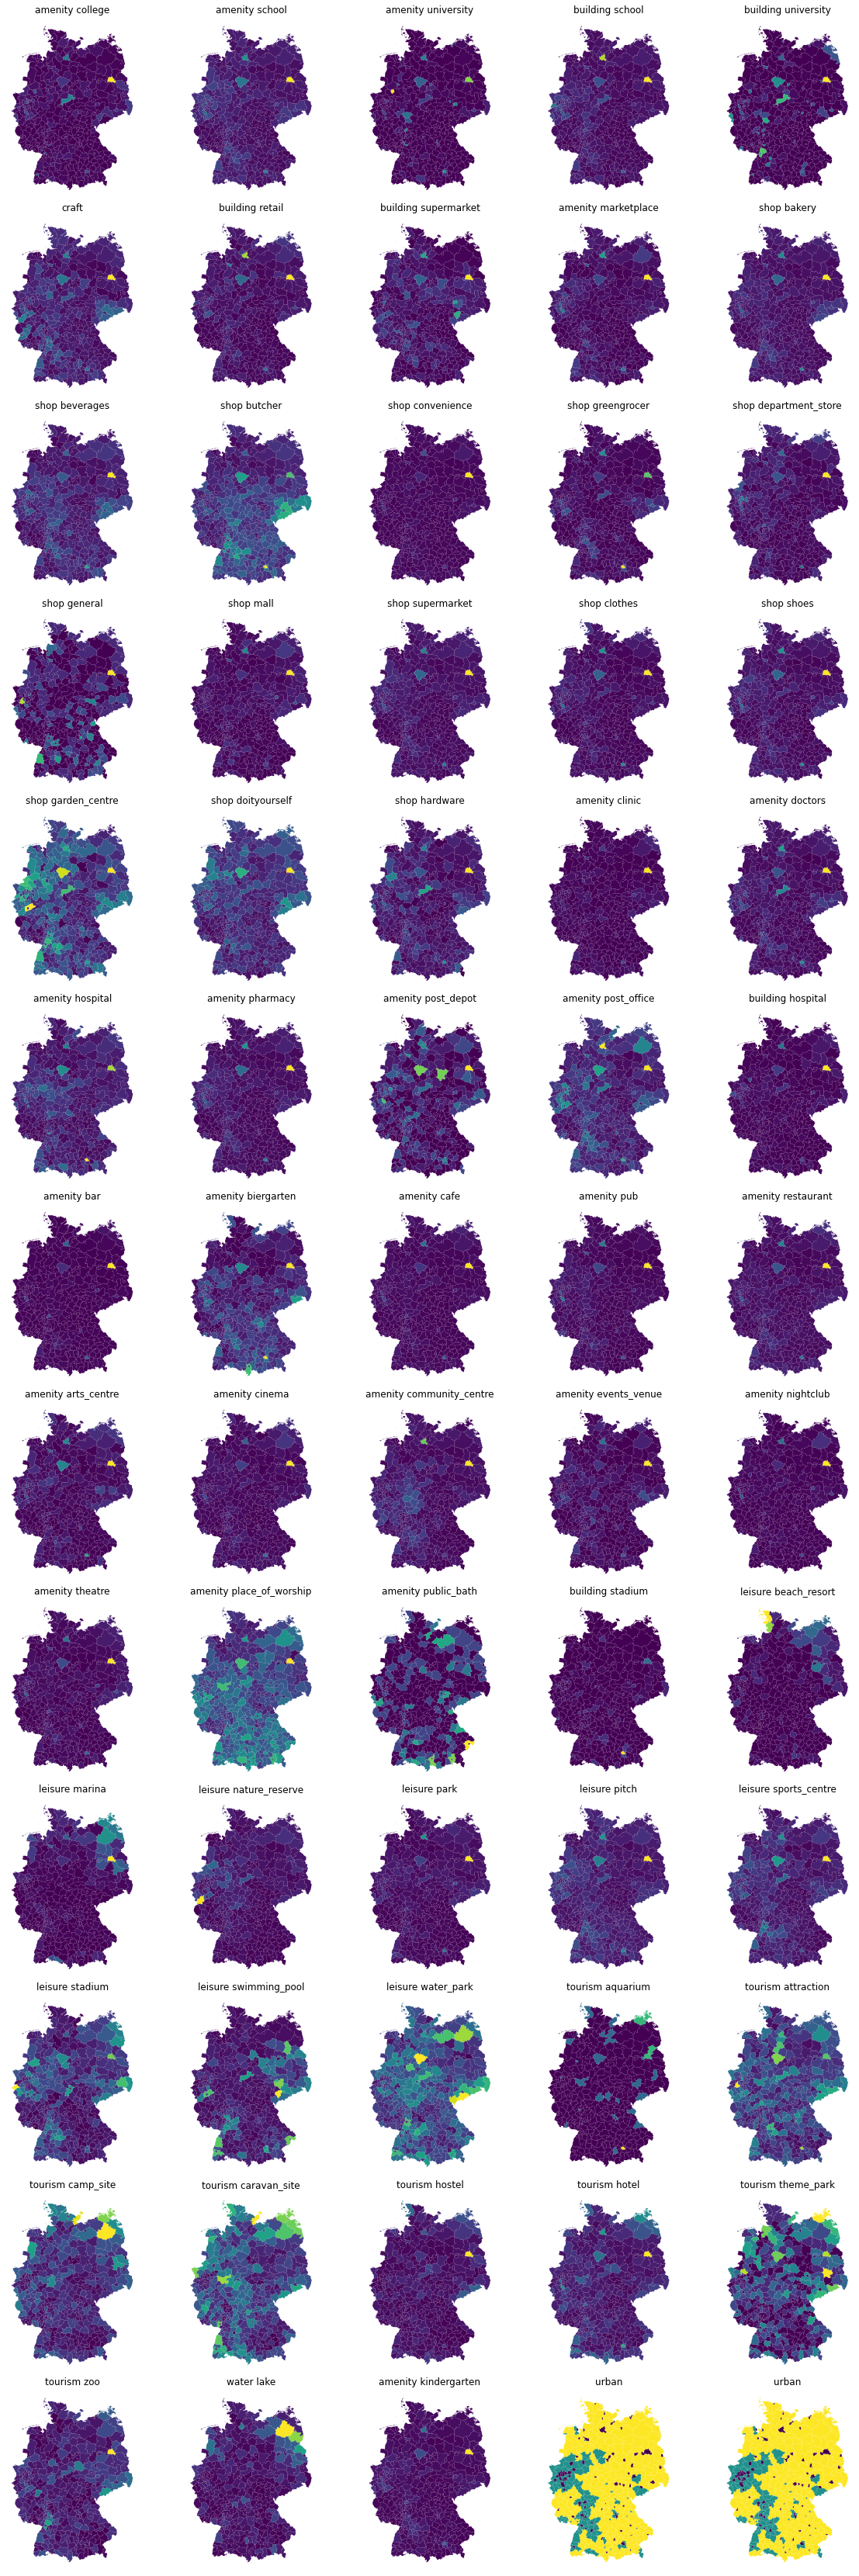

In [47]:
# Show maps
nrows = 13
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(16,46), sharex='all', sharey='all', constrained_layout=True)
col_num = 0
for i in range(nrows):
    for j in range(ncols):
        col = list(num_pois.columns)[col_num]
        sm.zones.plot(column=col, ax=ax[i,j], legend=False)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(col)
        col_num = min(len(num_pois.columns)-1, col_num+1)

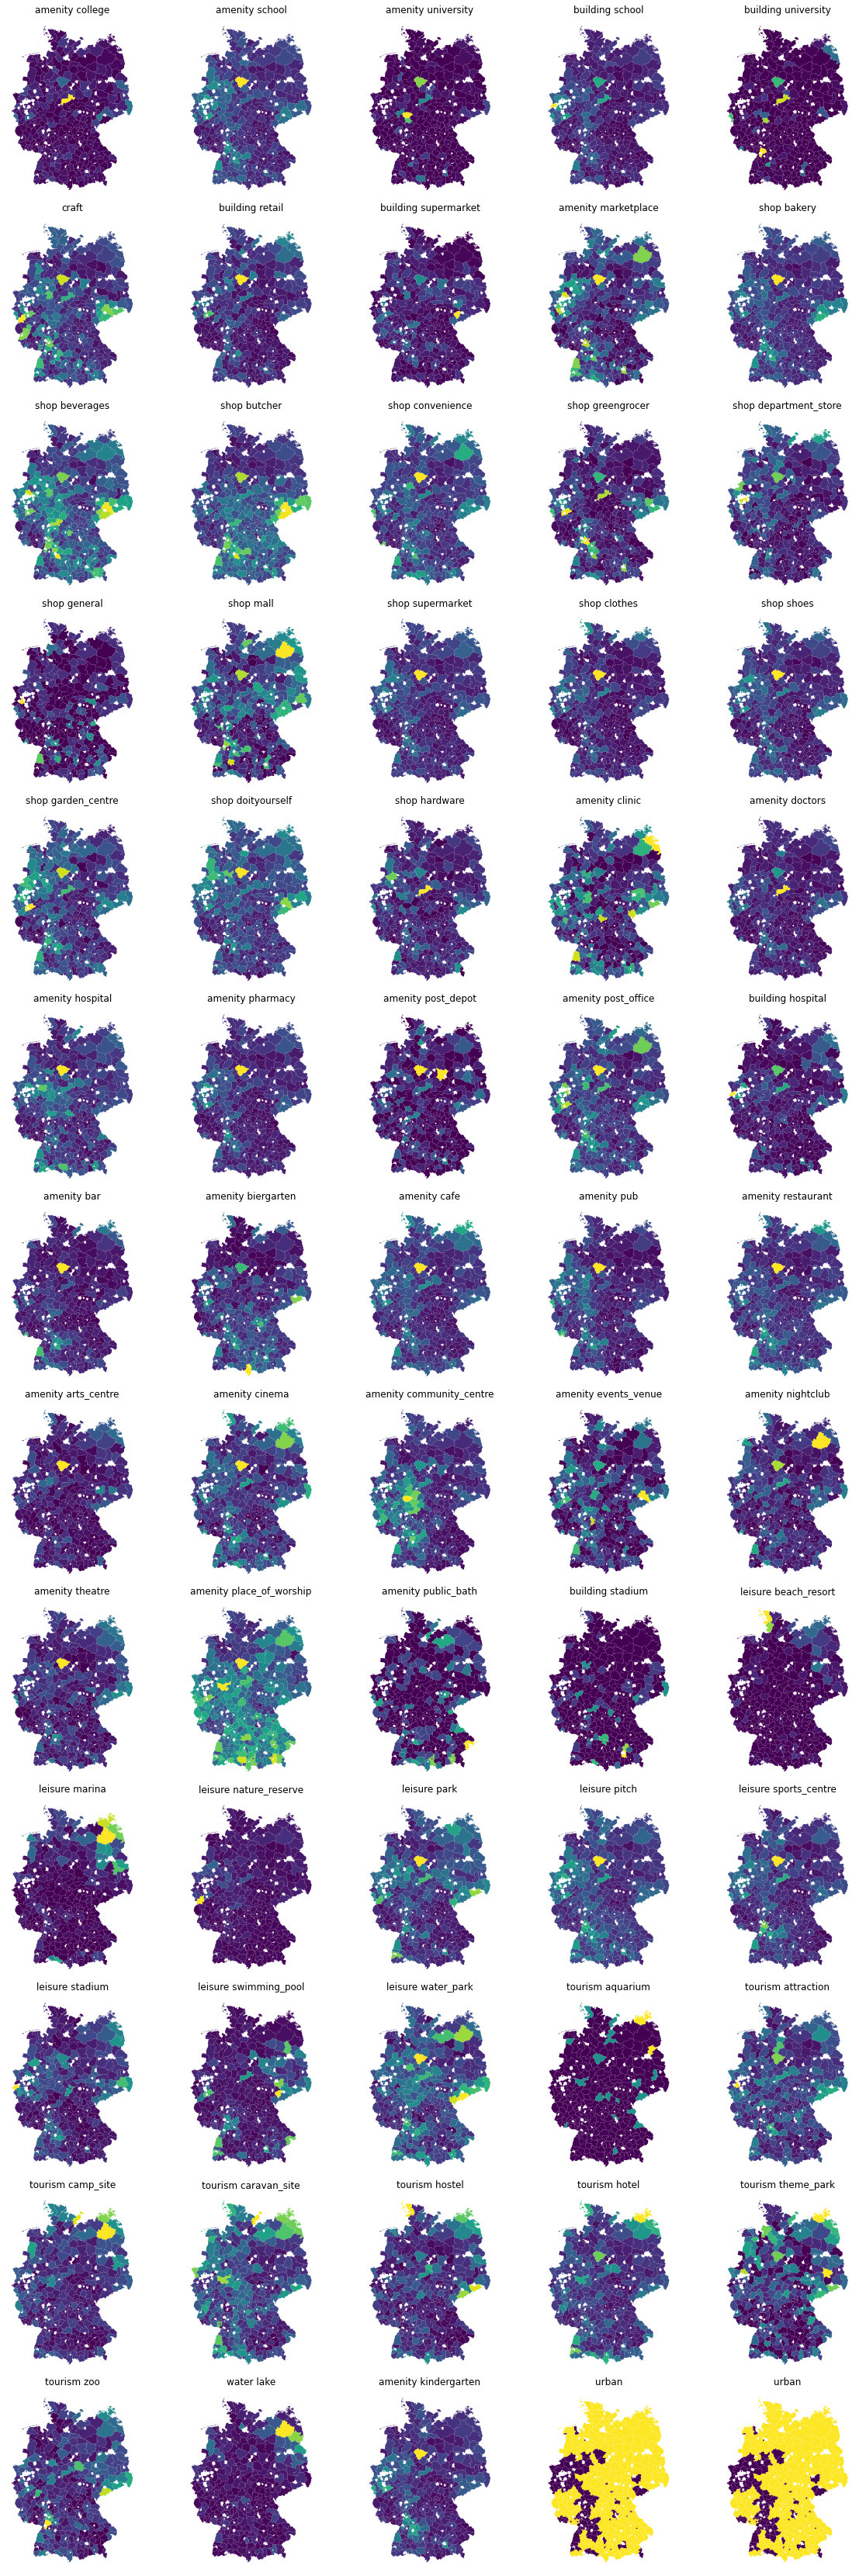

In [48]:
# Show maps, without urban
nrows = 13
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(16,46), sharex='all', sharey='all', constrained_layout=True)
col_num = 0
for i in range(nrows):
    for j in range(ncols):
        col = list(num_pois.columns)[col_num]
        sm.zones.loc[sm.zones['urbanisation']!=1].plot(column=col, ax=ax[i,j],
                                                       legend=False, missing_kwds={'color': 'lightgrey'})
        ax[i,j].set_axis_off()
        ax[i,j].set_title(col)
        col_num = min(len(num_pois.columns)-1, col_num+1)

In [32]:
# Load POI codes and purpose classifications
poi_codes = pd.read_excel(input_path + 'spatial_OSM_POI_list.xlsx')
# Fill empty purpose cells
poi_codes['purpose model'].interpolate('pad', inplace=True)
# Build POI names
poi_codes['poi'] = poi_codes['key'].fillna('None')
poi_codes.loc[poi_codes['value'].notna(), 'poi'] += ' ' + poi_codes.loc[poi_codes['value'].notna(), 'value']

In [33]:
# Aggregate by travel purpose
# Always differentiate in categories of many POIs and few POIs
num_pois['education_many'] = num_pois['craft'] + \
                             num_pois[['amenity school', 'building school']].mean(axis=1) + \
                             num_pois['amenity kindergarten']
num_pois['education_few'] = num_pois['amenity college'] + \
                            num_pois[['amenity university', 'building university']].mean(axis=1)
num_pois['shopping_many'] = num_pois[list(poi_codes.loc[(poi_codes['purpose model']=='shopping') &
                                                        (poi_codes['weight']!='large'),
                                                        'poi'])].sum(axis=1)
num_pois['shopping_few'] = num_pois[list(poi_codes.loc[(poi_codes['purpose model']=='shopping') &
                                                       (poi_codes['weight']=='large'),
                                                       'poi'])].sum(axis=1)
num_pois['leisure_many'] = num_pois[list(poi_codes.loc[(poi_codes['purpose model']=='leisure') &
                                                       (poi_codes['weight']!='large'),
                                                       'poi'])].sum(axis=1)
num_pois['leisure_few'] = num_pois[list(poi_codes.loc[(poi_codes['purpose model']=='leisure') &
                                                      (poi_codes['weight']=='large'),
                                                      'poi'])].sum(axis=1)
num_pois['accompany'] = num_pois[list(poi_codes.loc[(poi_codes['purpose model']=='accompany'),
                                                    'poi'])].sum(axis=1)

<AxesSubplot:>

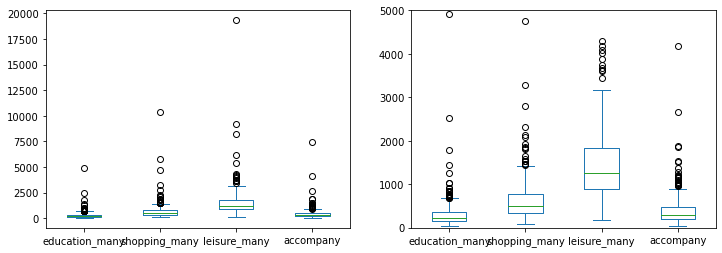

In [58]:
# purpose distribution for small-weighted POIs
fig, ax = plt.subplots(1,2, figsize=(12,4))
num_pois[['education_many', 'shopping_many', 'leisure_many', 'accompany']].plot.box(ax=ax[0])
num_pois[['education_many', 'shopping_many', 'leisure_many', 'accompany']].plot.box(ax=ax[1], ylim=(-5,5000))

<AxesSubplot:>

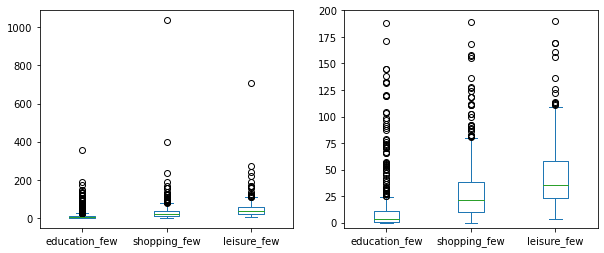

In [59]:
# purpose distribution for large-weighted POIs
fig, ax = plt.subplots(1,2, figsize=(10,4))
num_pois[['education_few', 'shopping_few', 'leisure_few']].plot.box(ax=ax[0])
num_pois[['education_few', 'shopping_few', 'leisure_few']].plot.box(ax=ax[1], ylim=(-5,200))

In [34]:
p_cols = ['education_many', 'education_few', 'shopping_many', 'shopping_few', 'leisure_many', 'leisure_few', 'accompany']
sm.zones[p_cols] = num_pois[p_cols]

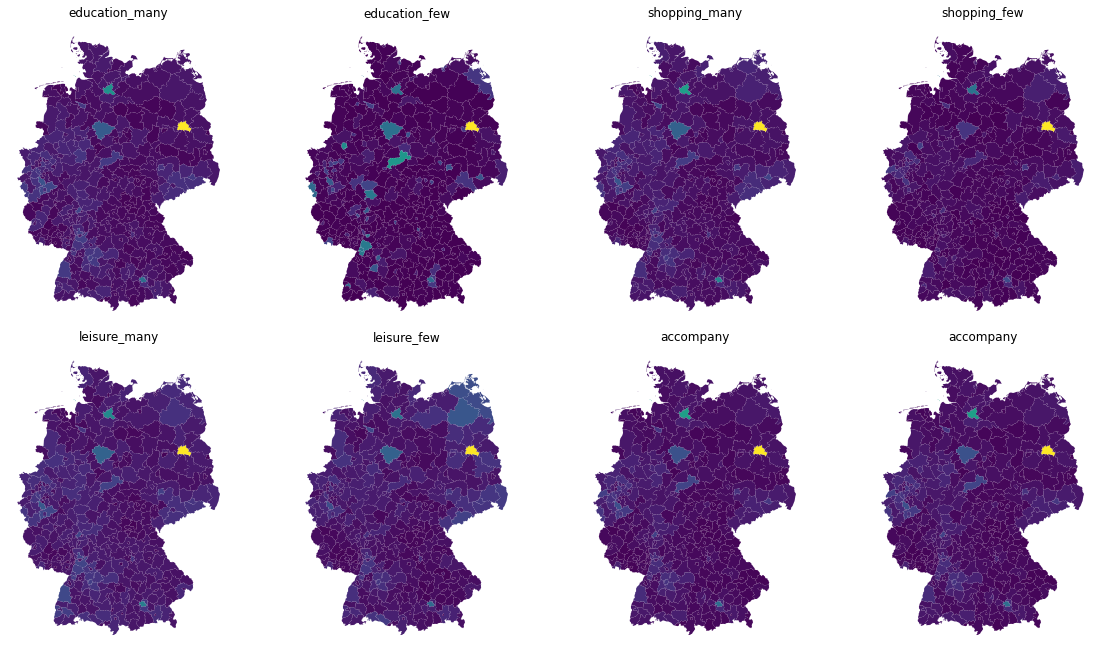

In [35]:
# Show maps of purposes
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(16,9), sharex='all', sharey='all', constrained_layout=True)
col_num = 0
for i in range(nrows):
    for j in range(ncols):
        col = p_cols[col_num]
        sm.zones.plot(column=col, ax=ax[i,j], legend=False)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(col)
        col_num = min(len(p_cols)-1, col_num+1)

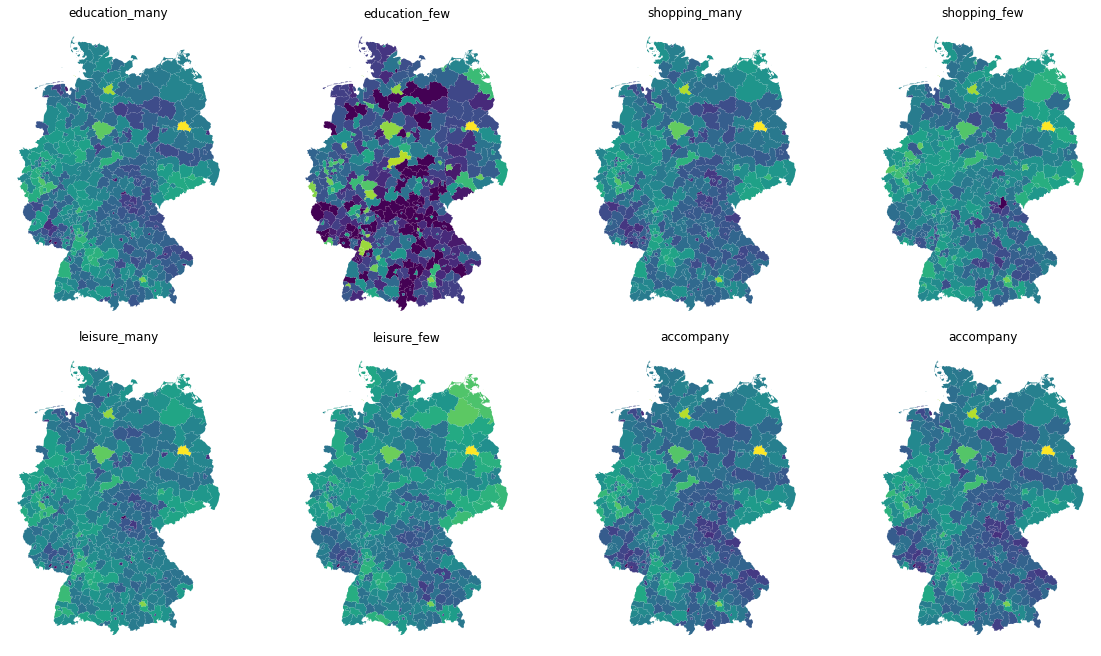

In [57]:
# Show maps of purposes with logarithm
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(16,9), sharex='all', sharey='all', constrained_layout=True)
col_num = 0
for i in range(nrows):
    for j in range(ncols):
        col = p_cols[col_num]
        sm.zones[col+'_log'] = (sm.zones[col] + 1).apply(np.log)
        sm.zones.plot(column=col+'_log', ax=ax[i,j], legend=False)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(col)
        col_num = min(len(p_cols)-1, col_num+1)

<AxesSubplot:>

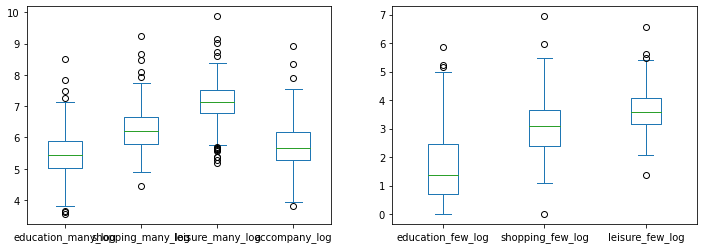

In [63]:
# purpose distribution for logarithm
fig, ax = plt.subplots(1,2, figsize=(12,4))
sm.zones[['education_many_log', 'shopping_many_log', 'leisure_many_log', 'accompany_log']].plot.box(ax=ax[0])
sm.zones[['education_few_log', 'shopping_few_log', 'leisure_few_log']].plot.box(ax=ax[1])

In [64]:
# Save
num_pois.to_csv(input_path + 'spatial_num_pois.csv')